# OptOut Project: Constructing Independent Variables

## For subsample - childbirth year >= 1980

March 2015

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from operator import itemgetter
from datetime import datetime

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# helper functions

def diff_month(d1, d2):
    """
    Return the number of months between the two dates
    """
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month


def print_full(x):
    """display full table in this notebook"""
    
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', x.shape[1])
    return x
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    
    
def list_duplicates_of(seq, item):
    """
    Given a seq and item, return the indexes of duplicate items in the list (as a list).
    (found online)
    """
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

# Week-to-week crosswalk

Create two functions to convert between week number and calendar year and month

In [3]:
#this is the file to switch between week number in NLSY79 and calendar year, month, and day
xl_file = pd.ExcelFile('../data/continuous_week_crosswalk_2012.xlsx') 
weekdf = xl_file.parse('weekdates1')
weekdf.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,1,1,1978,1,1
1,1,8,1978,2,2
2,1,15,1978,3,3
3,1,22,1978,4,4
4,1,29,1978,5,5


In [4]:
def get_week_num(year, month, which, df=weekdf):
    """
    Given a calendar year and month, return the corresponding week number in NLSY79.
    
    If which=='first', return the first week in that month.
    If which=='last', return the last week in that month. 
    """
    
    the_month = weekdf[(weekdf['Week Start:\nMonth']==month)&(weekdf['Week Start: \nYear']==year)]
    
    if which == 'first':
        return int(the_month.iloc[0]['Continuous \nWeek Number'])
    elif which == 'last':
        return int(the_month.iloc[len(the_month)-1]['Continuous \nWeek Number'])

In [5]:
def get_year_month(weeknum, df=weekdf):
    """
    Given a week number, return the corresponding calendar month and year (yyyy, m).
    """
    
    the_week = weekdf[weekdf['Continuous \nWeek Number']==weeknum]
    return int(the_week.iloc[0]['Week Start: \nYear']), int(the_week.iloc[0]['Week Start:\nMonth'])

# Get sub-sample with child birth year >= 1980

In [6]:
# read entire sample
iv_df = pd.read_csv('../data/iv_df.csv') 
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,...,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp,num_ft_months,num_pt_months,num_nonemp_months,num_nonemp_spells
0,2,1993,3,1959,1,1993,4,34,26370.0,1,...,17.0,3.0,3,2,20.0,439.0,14,78,123,1
1,3,1981,6,1961,8,1981,7,19,3817.0,1,...,15.0,4.0,3,3,28.0,677.0,50,9,157,9
2,4,1980,8,1962,8,1980,9,18,0.0,0,...,11.0,2.0,3,2,199.0,1212.0,107,25,78,5
3,8,1976,3,1958,7,1976,4,17,0.0,0,...,12.0,2.0,3,3,38.0,1472.0,138,13,50,3
4,16,1990,2,1958,10,1990,3,31,24275.0,1,...,11.0,2.0,3,3,42.0,1473.0,88,117,0,0


In [7]:
# keep only mothers with first birth after 1980
print iv_df.shape
iv_df = iv_df[iv_df.childbirth_year>=1980]
print iv_df.shape

(3434, 25)
(2514, 25)


# Construct IVs specific to subsample

### Hourly rate and tenure of the last job held one year pre-birth

NLSY79 has two sets of job variables, one under the section "employment history" and one under "employment roster." It seems like they are the same data (https://www.nlsinfo.org/content/cohorts/nlsy79/topical-guide/employment/nlsy79-employer-history-roster), except that employment roster made it easier to link across employers. 

The two methods returned results that are highly correlated. We will use method 1.  

In [8]:
# read datasets
hrrate_df = pd.read_csv("../data/hrrate.csv")
jobdates_df = pd.read_csv("../data/jobdates.csv") # week number when job starts/ends
cps_id_df = pd.read_csv("../data/cps_id_new.csv")
workhours_df = pd.read_csv("../data/hours_worked.csv") # hours per week worked on job
intdate_df = pd.read_csv("../data/int_date.csv") # interview dates
prevjobnum_df = pd.read_csv("../data/prev_job_num.csv") 

In [9]:
hrrate_df.columns[:10]

Index([u'caseid_1979', u'cpshrp_1979', u'hrp1_1979', u'hrp2_1979',
       u'hrp3_1979', u'hrp4_1979', u'hrp5_1979', u'cpshrp_1980', u'hrp1_1980',
       u'hrp2_1980'],
      dtype='object')

In [10]:
jobdates_df.columns[:-10]

Index([u'caseid_1979', u'start_wk_1979_job01_xrnd',
       u'start_wk_1979_job02_xrnd', u'start_wk_1979_job03_xrnd',
       u'start_wk_1979_job04_xrnd', u'start_wk_1979_job05_xrnd',
       u'stop_wk_1979_job01_xrnd', u'stop_wk_1979_job02_xrnd',
       u'stop_wk_1979_job03_xrnd', u'stop_wk_1979_job04_xrnd',
       ...
       u'start_wk_2010_job01_xrnd', u'start_wk_2010_job02_xrnd',
       u'start_wk_2010_job03_xrnd', u'start_wk_2010_job04_xrnd',
       u'start_wk_2010_job05_xrnd', u'stop_wk_2010_job01_xrnd',
       u'stop_wk_2010_job02_xrnd', u'stop_wk_2010_job03_xrnd',
       u'stop_wk_2010_job04_xrnd', u'stop_wk_2010_job05_xrnd'],
      dtype='object', length=241)

In [11]:
cps_id_df.columns[:10]

Index([u'caseid_1979', u'job01_1980', u'job02_1980', u'job03_1980',
       u'job04_1980', u'job05_1980', u'job01_1981', u'job02_1981',
       u'job03_1981', u'job04_1981'],
      dtype='object')

In [12]:
workhours_df.columns[:10]

Index([u'caseid_1979', u'job_01_1979', u'job_02_1979', u'job_03_1979',
       u'job_04_1979', u'job_05_1979', u'job_01_1980', u'job_02_1980',
       u'job_03_1980', u'job_04_1980'],
      dtype='object')

In [13]:
intdate_df.columns[:10]

Index([u'caseid_1979', u'date_m_1979', u'date_d_1979', u'date_m_1980',
       u'date_d_1980', u'date_m_1981', u'date_d_1981', u'date_m_1982',
       u'date_d_1982', u'date_m_1983'],
      dtype='object')

In [14]:
prevjobnum_df.columns[:10]

Index([u'caseid_1979', u'prev_emp_1980_job01', u'prev_emp_1980_job02',
       u'prev_emp_1980_job03', u'prev_emp_1980_job04', u'prev_emp_1980_job05',
       u'prev_emp_1981_job01', u'prev_emp_1981_job02', u'prev_emp_1981_job03',
       u'prev_emp_1981_job04'],
      dtype='object')

In [15]:
#find the range of job numbers: 1-5
import re
job_num = set([])

for col in jobdates_df.columns[1:]:
    job_num.add(re.search(r'job\d{2}', col).group(0)[3:])
    
print job_num

set(['02', '03', '01', '04', '05'])


In [16]:
# see what possible scenarios are out there

count = defaultdict(list)
count_missing = defaultdict(list)
years = range(1979, 1995) + range(1996, 2013, 2) # survey years


merged = iv_df.merge(jobdates_df, on='caseid_1979')


# count what kind of jobs we can find by one year prebirth
for i, row in merged.iterrows():
    
    # find birth year and month
    dob_m = int(row['childbirth_month'])
    dob_y = int(row['childbirth_year'])
    
    # find weeks in the month that is one year pre-birth
    # DO NOT assume birth took place in the last week of the month
    birth_weeks = range(get_week_num(dob_y-1, dob_m, 'first'), get_week_num(dob_y-1, dob_m, 'last')+1)

    # first, find all jobs that started before one year prebirth
    jobs = []
    
    for year in years:   
        for j in range(1, 6):
            start = int(row['start_wk_%i_job%02d_xrnd'%(year, j)])
            end = int(row['stop_wk_%i_job%02d_xrnd'%(year, j)])

            # job must have valid starting/ending week number and started before one year prebirth
            if start >= 0 and end >= 0 and start <= end:
                
                if start <= birth_weeks[-1]:
                    job_weeks = range(start, end+1)
                    if len(set(job_weeks)&set(birth_weeks)) > 0:
                        jobs.append((1, year, j, start, end)) # overlap with one year pre-birth
                    else:
                        jobs.append((0, year, j, start, end)) # only started before one year pre-birth

            elif start == -4 and end == -4: # valid skip
                pass 
            
            else:
                count_missing[row['caseid_1979']].append((year, j, start, end))
                    

    if len(jobs) == 0: # no job found one year pre-birth
        count['no_job'].append(row['caseid_1979'])
        
    else:
        overlap_jobs = [job for job in jobs if job[0] == 1]
        if len(overlap_jobs) == 1:
            count['one_overlap'].append(row['caseid_1979'])
        elif len(overlap_jobs) > 1:
            count['multi_overlap'].append(row['caseid_1979'])
        else:
            count['no_overlap'].append(row['caseid_1979'])
 


for k, v in count.items():
    print k, len(v)

no_job 198
multi_overlap 280
no_overlap 459
one_overlap 1577


In [17]:
# how many respondents have missing job dates?
len(count_missing.keys())

217

In [18]:
# check out the first 10 cases with missing dates
for i in range(len(count_missing)):
    k = count_missing.keys()[i]
    print k, count_missing[k]
    
    if i > 10:
        break

3073.0 [(1990, 2, 602, 600)]
1538.0 [(2010, 2, -2, 1669)]
7689.0 [(2010, 1, -2, 1561)]
3079.0 [(1996, 1, 961, 960)]
2569.0 [(1996, 1, 966, 965)]
5135.0 [(1990, 1, 663, 660), (1990, 3, 603, -3)]
4112.0 [(2006, 2, 1269, -2), (2012, 1, -2, 1822)]
2066.0 [(1988, 2, -3, -3)]
19.0 [(1980, 2, 61, 60)]
6164.0 [(1980, 1, 87, 86)]
9817.0 [(1989, 1, 556, -3)]
4632.0 [(1987, 3, 426, -3)]


## <font color='blue'>Consider each scenario</font>



'multi overlaps': 167,
             'multi overlaps, 2 jobs diff year': 9,
             'multi overlaps, 2 jobs same year, hours': 14,
             'multi overlaps, 2 jobs same year, sort job number': 134,
             'multi overlaps, 3+ jobs, hours': 3,
             'multi overlaps, 3+ jobs, sort job year': 7,



### Scenario 1: no job is found (198 cases)

R had never worked before (198 cases). Hourly rate 0. Tenure 0. As expected, these respondents have 0 for the variable whether working at one year prebirth and 0 for the variable whehter ever held a job one year prebirth. 


<font color='red'>Drop repeated jobs</font>. If a job lasted multiple years and were reported in multiple survey waves, track the same job and drop earlier references of the same job.


### Scenario 2: no overlap (459 cases)

Use the job that lasted the closest to the prebirth date. We previously chosen the job that started the latest by one year prebirth, but the job that lasted the longest is a better choice because this is the job that was active at the time closest to the point one year prebirth. For example, if a respondent had child in June 1989, her one year prebirth is June 1988. She had one job that started in January 1987 adn ended in January 1988, and another job that started in February 1987 and ended in May 1988. We would want to pick the second job to retrieve hourlyr ate and tenure. 

A small number of respondents have multiple jobs ending in the same week. Try three approaches in order to determine the job to retrieve job traits. 
(1) Look for the job with the max weekly hours worked (0 case)
(2) Look for the job with the smallest job number (among jobs reported in the same year) (4 case)


### Scenario 3: one overlap (1690 cases)

If the overlaping job was reported in the same year as prebirth year, use it to retrieve job traits. Otherwise, try to trace back to the previous job reported <= prebirth year or closest to prebirth year, and use it to retrieve job traits. 


### Scenario 4: multiple overlaps

* If there are two overlapping jobs, 
    * If they were reported in different years, pick the one that was reported closer to prebirth year (9 cases)
    * otherwise, look for the job with the max weekly hours worked (14 case); or look for the job with the smallest job number (134 cases). 

* If there are more than 2 overlapping jobs, print out their respondent id, prebirth year/month, and overlapping jobs information. First, look for the job with the max weekly hours worked (3 case). If still undecided, look for the job reported closer to prebirth year (7 cases).

In [19]:
# helper functions


years = range(1979, 1995) + range(1996, 2013, 2)


def is_prev_job(i, y0, n0, y, n):
    """
    Return whether y0, n0 is previous job of y, n.
    
    i is respondent id.
    """
    
    # does not apply when two jobs reported in the same survey year
    if y0 == y:
        return False
    
    # find the previous job number reported for job n in year y
    prev_job_num = prevjobnum_df[prevjobnum_df.caseid_1979==i].iloc[0]['prev_emp_%i_job%02d'%(y, n)]
    
    # if found a valid prev job number
    if prev_job_num >= 1:
        
        ###### find which is the previous year ######
        # there might be missing years, and we will need to skip a few years
        intdate_row = intdate_df[intdate_df.caseid_1979==i].iloc[0]
        
        # pick valid years by checking whether there is valid interview date
        valid_years = [x for x in years if x < y and intdate_row['date_m_%i'%x] > 0]
        
        # the last valid year is the previous year that the previous job was reported 
        prev_year = valid_years[-1]
        
        if prev_year == y0:
            return prev_job_num==n0
        if prev_year > y0 and prev_job_num <= 5:
            return is_prev_job(i, y0, n0, prev_year, prev_job_num)
        
    return False


def drop_redundant_jobs(i, jobs):
    """
    Jobs that last across multiple survey years have a separate report in each survey year. 
    Drop the earlier references. Return the latest reference. 
    
    i is respondent id. 
    """
    
    jobs = sorted(jobs, key=itemgetter(1)) # sort by year
    to_drop = []
    for j in range(len(jobs)):
        for k in range(j+1, len(jobs)):
            if is_prev_job(i, jobs[j][1], jobs[j][2], jobs[k][1], jobs[k][2]):
                to_drop.append(j)    
                break # stop searching further because each job is only linked to one previous job

    unique_jobs = [jobs[j] for j in range(len(jobs)) if not (j in to_drop)]  
    return unique_jobs


# def find_primary_job_by_cps(i, jobs):
#     """
#     Use CPS to identify the primary job. CPS job is the primary job. Otherwise, return None. 
#     """

#     try:
#         row = cps_id_df[cps_id_df.caseid_1979==i].iloc[0]
#         cps_ids = [row['job%02d_%i'%(job[2], job[1])] for job in jobs]
#         if cps_ids.count(1) == 1:
#             return jobs[cps_ids.index(1)]
            
#     except KeyError:
#         return None

#     return None


def find_primary_job_by_hours(i, jobs):
    """
    Use weekly hours worked to identify the primary job. 
    The most worked job is the primary job. 
    
    If any job has missing hours, return None. 
    If multiple jobs have same max hours, return None. 
    """

    hour_row = workhours_df[workhours_df.caseid_1979==i].iloc[0]
    hours = []
    for job in jobs:
        if hour_row["job_%02d_%i"%(job[2], job[1])] >= 0:
            hours.append(hour_row["job_%02d_%i"%(job[2], job[1])])  
        else:
            return None
    
    most_hour = max(hours)
    if hours.count(most_hour) == 1:
        return jobs[hours.index(most_hour)]
    return None


def get_ref_in_given_year(i, y, n, prebirth_y):
    """
    Given respondent id i, job year y, and job number n, 
    trace the job back to prebirth year and return the job number. 
    
    If missing data in prebirth year, return the job in the latest year before prebirth year.
    """
    
    if y == 1979: # can't go back further than the first wave
        return (y, n)
    
    prev_job_num = prevjobnum_df[prevjobnum_df.caseid_1979==i].iloc[0]['prev_emp_%i_job%02d'%(y, n)]
    
    # if found a valid prev job number
    if prev_job_num >= 1:
        
        # find which is the previous year. due to noninterview, we might have to skip a few years
        intdate_row = intdate_df[intdate_df.caseid_1979==i].iloc[0]
        valid_years = [x for x in years if x < y and intdate_row['date_m_%i'%x] > 0]
        prev_year = valid_years[-1]
        
        if prev_year <= prebirth_y:
            return (prev_year, prev_job_num)
        
        else:
            return get_ref_in_given_year(i, prev_year, prev_job_num, prebirth_y)
        
    else:
        return (y, n)
  

def get_first_ref(i, y, n):
    """
    Given respondent id i, job year y, and job number n, 
    find the first reference the job was reported. 
    """
    
    if y == 1979: # already reached the first survey wave
        return (y, n)
    
    prev_job_num = prevjobnum_df[prevjobnum_df.caseid_1979==i].iloc[0]['prev_emp_%i_job%02d'%(y, n)]
    
    if prev_job_num > 5: # unable to trace back, stop here
        return (y, n)

    elif prev_job_num >= 1: # found a valid prev job number
        
        # find which is the previous year. due to noninterview, we might have to skip a few years
        intdate_row = intdate_df[intdate_df.caseid_1979==i].iloc[0]
        valid_years = [x for x in years if x < y and intdate_row['date_m_%i'%x] > 0]
        prev_year = valid_years[-1]
        
        return get_first_ref(i, prev_year, prev_job_num)
        
    else:
        return (y, n)
    

def get_rate(i, job_year, job_num):
    """
    Return hourly rate of the given job. 
    """
    
    rate = hrrate_df[hrrate_df.caseid_1979==i].iloc[0]["hrp%i_%i"%(job_num, job_year)]
    if rate < 0:
        rate = None
    return rate


def get_tenure(row, y, n, end, prebirth_weeks):
    """
    If job ended during prebirth weeks, use job ending week - job starting week + 1 as tenure. 
    If job ended after prebirth week, use last prebirith week - job starting week + 1 as tenure. 
    
    Two possible ways of under-counting:
    - If a job started in week 0. The weeks prior to 1/1/1978 are unknown
    - When tracing back to previous job, the job was not reported in first five jobs
    """
    
    # first reference when chosen job was reported
    y0, n0 = get_first_ref(row['caseid_1979'], y, n)
    start = int(row['start_wk_%i_job%02d_xrnd'%(y0, n0)])
    
    if start >= 0: # valid value

        # if job ended before prebirth month
        if end <= prebirth_weeks[-1]:
            return end - start + 1
        else:
            return prebirth_weeks[-1] - start + 1

    return None

In [21]:
counts = defaultdict(int) # count cases


def get_job_traits(row):
    """
    Given a row of respondent data, return hourly rate, 
    rate year (in which hourly rate was reported), and tenure. 
    
    Consider 4 scenarios.
    """
        
    # find birth year and month
    prebirth_y = int(row['childbirth_year']) - 1
    prebirth_m = int(row['childbirth_month'])
    
    
    # find weeks in the month that is one year pre-birth
    # DO NOT assume birth took place in the last week of the month
    prebirth_weeks = range(get_week_num(prebirth_y, prebirth_m, 'first'), 
                           get_week_num(prebirth_y, prebirth_m, 'last')+1)

    # first, find all jobs that started before one year prebirth
    jobs = []
    
    for year in years:   
        for j in range(1, 6):
            start = int(row['start_wk_%i_job%02d_xrnd'%(year, j)])
            end = int(row['stop_wk_%i_job%02d_xrnd'%(year, j)])

            # job must have valid starting/ending week number and started before one year prebirth
            if start >= 0 and end >= 0 and start <= end:
                
                if start <= prebirth_weeks[-1]:
                    job_weeks = range(start, end+1)
                    if len(set(job_weeks)&set(prebirth_weeks)) > 0:
                        jobs.append((1, year, j, start, end)) # overlap with one year pre-birth
                    else:
                        jobs.append((0, year, j, start, end)) # only started before one year pre-birth
                    

    ###### scenario 1: no job reported one year prebirth ######
    if len(jobs) == 0:
        counts['no job'] += 1
        return (0, None, None, None, 0)
    

    
    # drop redundance job. keep the latest references of the same jobs
    jobs = drop_redundant_jobs(row['caseid_1979'], jobs)
    overlap_jobs = [job for job in jobs if job[0] == 1]
    
    chosen_job = None # the job to retrieve hourly rate and tenure
    
    ###### scenario 2: there are jobs, not no overlap with prebirth weeks ######
    
    if len(overlap_jobs) == 0:
        counts['no overlap'] += 1
        
        # choose the job that ended closest to prebirth time
        jobs = sorted(jobs, key=itemgetter(4), reverse=True) # sort by ending week 

        max_wk = jobs[0][4]
        max_end_jobs = [job for job in jobs if job[4] == max_wk] # job(s) with largest ending week

        if len(max_end_jobs) == 1:
            chosen_job = max_end_jobs[0] 
        else:
            # print row['caseid_1979'], (dob_y-1, dob_m), jobs, '\n'

            # if multiple job ended closest to prebirth, pick the job with max weekly hours
            # if still undecided, choose job with smallest job number
            
            #chosen_job = find_primary_job_by_cps(i, max_end_jobs)

            #if chosen_job: # found by cps approach
            #    counts['no overlap, cps'] += 1
            
            chosen_job = find_primary_job_by_hours(i, max_end_jobs)

            if chosen_job: # found by max weekly hour approach
                counts['no overlap, hours'] += 1
            else:
                counts['no overlap, sort job number'] += 1
                max_end_jobs = sorted(max_end_jobs, key=itemgetter(2)) # sort by job number
                chosen_job = max_end_jobs[0] # pick the smallest job number
             
        # chosen job was reported in or before prebirth year
        if chosen_job[1] <= prebirth_y: 
            rate = get_rate(row['caseid_1979'], chosen_job[1], chosen_job[2])
            report_year = chosen_job[1]
            start_week = chosen_job[3]
            end_week = chosen_job[4]
            return (rate, report_year, start_week, end_week, 0)

        # otherwise, trace back and find the chosen job reported in prebirth year, 
        # or the latest year before prebirth year
        else:
            y, n = get_ref_in_given_year(row['caseid_1979'], chosen_job[1], chosen_job[2], prebirth_y)
            rate = get_rate(row['caseid_1979'], y, n)
            report_year = y
            start_week = int(row['start_wk_%i_job%02d_xrnd'%(y, n)])
            end_week = int(row['stop_wk_%i_job%02d_xrnd'%(y, n)])
            return (rate, report_year, start_week, end_week, 0)

                
    ###### scenario 3: there is one overlap job ######           
    elif len(overlap_jobs) == 1:
        counts['one overlap'] += 1
        chosen_job = overlap_jobs[0]
        
     
    ###### scenario 4: multiple overlapping jobs ######
    elif len(overlap_jobs) > 1:
        counts['multi overlaps'] += 1
      
        if len(overlap_jobs) == 2:
            # two jobs reported in different years, pick the one reported closer to prebirth year
            if overlap_jobs[0][1] != overlap_jobs[1][1]: 
                counts['multi overlaps, 2 jobs diff year'] += 1
                overlap_jobs = sorted(overlap_jobs, key=itemgetter(1))
                chosen_job = overlap_jobs[0]

            else:
                
                #chosen_job = find_primary_job_by_cps(i, overlap_jobs)
                #if chosen_job: # found by cps approach
                #    counts['multi overlaps, 2 jobs same year, cps'] += 1
                
                chosen_job = find_primary_job_by_hours(i, overlap_jobs)

                if chosen_job: # found by max weekly hour approach
                    counts['multi overlaps, 2 jobs same year, hours'] += 1
                else:
                    counts['multi overlaps, 2 jobs same year, sort job number'] += 1
                    max_end_jobs = sorted(overlap_jobs, key=itemgetter(2)) # sort by job number
                    chosen_job = overlap_jobs[0] # pick the smallest job number

        else:
            print row['caseid_1979'], (prebirth_y, prebirth_m), overlap_jobs
            
            #cps_job = find_primary_job_by_hours(row['caseid_1979'], overlap_jobs)
            #if cps_job:
            #    counts['multi overlaps, 3+ jobs, cps'] += 1
            #    chosen_job = cps_job

            most_hour_job = find_primary_job_by_hours(row['caseid_1979'], overlap_jobs)
            if most_hour_job:
                counts['multi overlaps, 3+ jobs, hours'] += 1
                chosen_job = most_hour_job 
            else:
                counts['multi overlaps, 3+ jobs, sort job year'] += 1
                # pick the job reported closer to prebirth year
                jobs = sorted(jobs, key=itemgetter(1))
                chosen_job = jobs[0]                     
    
    
    ### retrieve job traits of the chosen job in scenario 3 & 4 ###
    # chosen job was reported in or before prebirth year
    if chosen_job[1] == prebirth_y: 
        rate = get_rate(row['caseid_1979'], chosen_job[1], chosen_job[2])
        report_year = prebirth_y
        start_week = chosen_job[3]
        end_week = chosen_job[4]
        tenure = get_tenure(row, chosen_job[1], chosen_job[2], chosen_job[4], prebirth_weeks)
        return (rate, report_year, start_week, end_week, tenure)

    # otherwise, trace back and find the chosen job reported in prebirth year 
    # or the latest year before prebirth year
    else:
        y, n = get_ref_in_given_year(row['caseid_1979'], chosen_job[1], chosen_job[2], prebirth_y)
        rate = get_rate(row['caseid_1979'], y, n)
        report_year = y
        start_week = int(row['start_wk_%i_job%02d_xrnd'%(y, n)])
        end_week = int(row['stop_wk_%i_job%02d_xrnd'%(y, n)])
        tenure = get_tenure(row, chosen_job[1], chosen_job[2], chosen_job[4], prebirth_weeks)
        return (rate, report_year, start_week, end_week, tenure)
    

    print 'uncaptured:', row['caseid_1979']

    
                      
merged = iv_df.merge(jobdates_df, on='caseid_1979')
res = merged.apply(get_job_traits, axis=1)

merged['rate'] = map(itemgetter(0), res)
merged['report_y'] = map(itemgetter(1), res)
merged['start_wk'] = map(itemgetter(2), res)
merged['end_wk'] = map(itemgetter(3), res)
merged['tenure'] = map(itemgetter(4), res)
iv_df = iv_df.merge(merged[['caseid_1979', 'rate', 'report_y', 'start_wk', 'end_wk', 'tenure']], on='caseid_1979')
iv_df.head()

3156.0 (1992, 5) [(1, 1992, 1, 714, 759), (1, 1992, 2, 714, 759), (1, 1992, 4, 704, 757)]
3248.0 (1987, 10) [(1, 1988, 1, 488, 558), (1, 1988, 2, 488, 543), (1, 1988, 3, 510, 540)]
3586.0 (1988, 8) [(1, 1988, 3, 527, 554), (1, 1989, 2, 555, 570), (1, 1989, 3, 555, 566)]
3928.0 (1979, 8) [(1, 1980, 1, 64, 111), (1, 1980, 2, 85, 111), (1, 1980, 3, 77, 95)]
4424.0 (1993, 6) [(1, 1993, 3, 770, 806), (1, 1994, 1, 809, 863), (1, 1994, 2, 809, 863)]
4664.0 (1994, 9) [(1, 1996, 1, 871, 913), (1, 1996, 2, 871, 913), (1, 1996, 3, 871, 913)]
7492.0 (1983, 1) [(1, 1983, 1, 225, 272), (1, 1983, 2, 225, 272), (1, 1983, 3, 263, 272), (1, 1983, 4, 233, 263)]
9789.0 (1984, 8) [(1, 1985, 1, 317, 368), (1, 1985, 2, 343, 363), (1, 1985, 3, 346, 363)]
9877.0 (1984, 4) [(1, 1985, 1, 321, 373), (1, 1985, 2, 321, 359), (1, 1985, 3, 321, 359)]
9885.0 (1980, 3) [(1, 1981, 1, 115, 137), (1, 1981, 2, 115, 126), (1, 1981, 3, 115, 115)]


,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,...,yr_cum_exp,num_ft_months,num_pt_months,num_nonemp_months,num_nonemp_spells,rate,report_y,start_wk,end_wk,tenure
0,2,1993,3,1959,1,1993,4,34,26370.0,1,...,439.0,14,78,123,1,1263.0,1992.0,706.0,775.0,726.0
1,3,1981,6,1961,8,1981,7,19,3817.0,1,...,677.0,50,9,157,9,397.0,1980.0,118.0,124.0,14.0
2,4,1980,8,1962,8,1980,9,18,0.0,0,...,1212.0,107,25,78,5,0.0,NaN,NaN,NaN,0.0
3,16,1990,2,1958,10,1990,3,31,24275.0,1,...,1473.0,88,117,0,0,1586.0,1989.0,560.0,609.0,130.0
4,19,1987,11,1957,12,1987,12,29,10241.0,1,...,0.0,0,0,216,1,565.0,1986.0,411.0,426.0,56.0


In [22]:
counts

defaultdict(int,
            {'multi overlaps': 167,
             'multi overlaps, 2 jobs diff year': 9,
             'multi overlaps, 2 jobs same year, hours': 14,
             'multi overlaps, 2 jobs same year, sort job number': 134,
             'multi overlaps, 3+ jobs, hours': 3,
             'multi overlaps, 3+ jobs, sort job year': 7,
             'no job': 198,
             'no overlap': 459,
             'no overlap, sort job number': 4,
             'one overlap': 1690})

In [23]:
# as expected: people who held no job prebirth scored 0 in the working variable
iv_df[iv_df.rate==0].working.unique()

array([0])

In [24]:
# as expected: people who held no job prebirth scored 0 in the had_job variable
iv_df[iv_df.rate==0].had_job.unique()

array([0])

In [25]:
# number of missing hourly rates
sum(iv_df.rate.isnull())

204

In [26]:
# number of missing tenure
sum(iv_df.tenure.isnull())

2

In [27]:
iv_df[(iv_df.start_wk<=0)|(iv_df.end_wk<=0)]

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,...,yr_cum_exp,num_ft_months,num_pt_months,num_nonemp_months,num_nonemp_spells,rate,report_y,start_wk,end_wk,tenure
89,333,1980,10,1957,2,1980,11,23,3880.0,1,...,1875.0,145,61,7,1,562.0,1979.0,0.0,69.0,97.0
91,338,1980,7,1959,12,1980,8,20,2430.0,1,...,1645.0,183,0,33,1,333.0,1979.0,0.0,65.0,84.0
183,704,1980,8,1958,6,1980,9,22,3520.0,1,...,2060.0,214,0,0,0,726.0,1979.0,0.0,67.0,88.0
268,1056,1980,1,1959,7,1980,2,20,2088.0,1,...,1563.0,137,39,40,5,320.0,1979.0,0.0,60.0,58.0
277,1090,1980,11,1964,3,1980,12,16,NaN,0,...,852.0,82,17,107,8,100.0,1979.0,0.0,63.0,0.0
342,1352,1980,10,1958,10,1980,11,22,3880.0,1,...,378.0,38,12,166,4,319.0,1979.0,0.0,60.0,97.0
486,1868,1980,10,1957,8,1980,11,23,3395.0,1,...,1369.0,128,8,76,2,357.0,1979.0,0.0,66.0,97.0
544,2104,1980,2,1957,1,1980,3,23,2400.0,1,...,1350.0,95,66,38,4,375.0,1979.0,0.0,63.0,62.0
606,2368,1980,4,1957,6,1980,5,22,2627.0,1,...,2014.0,214,0,0,0,NaN,1979.0,0.0,64.0,71.0
764,2970,1980,12,1957,10,1981,1,23,NaN,1,...,0.0,0,0,216,1,NaN,1979.0,0.0,80.0,106.0


<font color='red'>Two cases have job dates -4: respondent 6472 and 9916</font>. They both have no overlapping job, so their tenure should be zero. Their chosen job for retrieving job traits were both reported a year after prbirht year, so I traced the jobs back and found the same job reported in the prebirth year. However, these jobs reported -4 as start and end week. These two cases also have missing hourly rate, so I'm going to treat them as missing. 

In [37]:
# the gap (number of years) between the year hourly rate was reported and prebirth year
# positive number means the year hourly rate was reported is after prebirth year

# the 19-year gap happened to respondent 5767. she had one overlapping job (2002, 2, 146, 1287) 
# that wasn't reported before

gap = iv_df.report_y - (iv_df.childbirth_year - 1)
gap.value_counts()

 0.0     1741
 1.0      391
-1.0       92
-2.0       30
-3.0       13
-4.0       12
 2.0       11
 3.0        5
 4.0        5
-5.0        5
-6.0        2
 19.0       1
 8.0        1
 6.0        1
 5.0        1
-14.0       1
-12.0       1
-11.0       1
-7.0        1
 10.0       1
dtype: int64

In [38]:
# it may be problematic when the gap is large
# when we convert hourly rate to 2016 dollar, the conversion rate varies by year

# I think we should use the year when the job ended as the year for conversion rate because 
# hourly rate is more likely to be recalled at the time the job ended

def convert_to_year_helper(x):
    """
    Convert week number to year
    """
    if pd.isnull(x):
        return None
    elif x == 0: # only know it's prior to 1/1/1978
        return 1977
    else:
        return get_year_month(x)[0]
    
def convert_to_year(row, name):
    """
    Convert week number to year
    """
    if pd.isnull(row['rate']):
        return None
    return convert_to_year_helper(row[name])

iv_df['start_year'] = iv_df.apply(lambda row: convert_to_year(row, 'start_wk'), axis=1)
iv_df['end_year'] = iv_df.apply(lambda row: convert_to_year(row, 'end_wk'), axis=1)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,...,num_pt_months,num_nonemp_months,num_nonemp_spells,rate,report_y,start_wk,end_wk,tenure,start_year,end_year
0,2,1993,3,1959,1,1993,4,34,26370.0,1,...,78,123,1,1263.0,1992.0,706.0,775.0,726.0,1991.0,1992.0
1,3,1981,6,1961,8,1981,7,19,3817.0,1,...,9,157,9,397.0,1980.0,118.0,124.0,14.0,1980.0,1980.0
2,4,1980,8,1962,8,1980,9,18,0.0,0,...,25,78,5,0.0,NaN,NaN,NaN,0.0,NaN,NaN
3,16,1990,2,1958,10,1990,3,31,24275.0,1,...,117,0,0,1586.0,1989.0,560.0,609.0,130.0,1988.0,1989.0
4,19,1987,11,1957,12,1987,12,29,10241.0,1,...,0,216,1,565.0,1986.0,411.0,426.0,56.0,1985.0,1986.0


In [39]:
# end year is the same or before report year
tmp = iv_df[~iv_df.end_year.isnull()] # remove missing
(tmp.end_year - tmp.report_y).value_counts()

 0.0    1762
-1.0     337
-2.0       5
-3.0       2
-4.0       2
-6.0       2
-5.0       1
-8.0       1
dtype: int64

In [40]:
# end year compared to prebirth year
tmp = iv_df[~iv_df.end_year.isnull()] # remove missing
(tmp.end_year - (tmp.childbirth_year-1)).value_counts()

 0.0     1616
 1.0      212
-1.0      188
-2.0       47
-3.0       17
-4.0       11
-5.0        5
-6.0        3
 4.0        3
 3.0        3
 2.0        3
-12.0       1
-15.0       1
 19.0       1
 8.0        1
dtype: int64

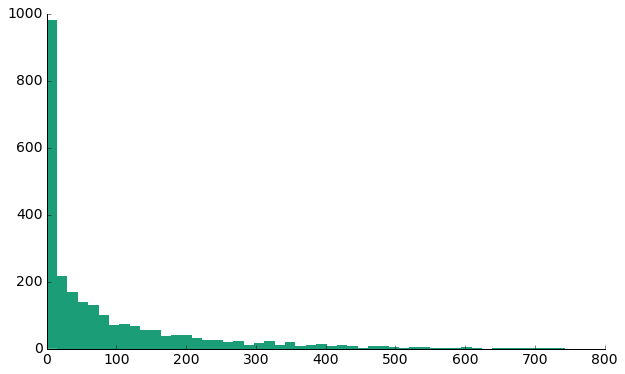

In [41]:
# distribution of tenure
t = iv_df[~iv_df.tenure.isnull()].tenure # remove missing
plt.hist(t, bins=50)
remove_border()

### Convert Hourly Rate to 2016 Dollars

Use the CPI inflation calculator to convert from January of the various year to January of 2016.

https://www.bls.gov/data/inflation_calculator.htm

In [42]:
iv_df.end_year.unique()

array([ 1992.,  1980.,    nan,  1989.,  1986.,  1985.,  1981.,  1984.,
        1993.,  1982.,  1979.,  1983.,  1991.,  1987.,  1990.,  1988.,
        1994.,  1978.,  2002.,  1996.,  1995.,  1998.])

In [43]:
#conversation rates gotten from http://data.bls.gov/cgi-bin/cpicalc.pl

convert_dict = {
    1978: 3.79,
    1979: 3.43,
    1980: 3.05,
    1981: 2.72,
    1982: 2.51,
    1983: 2.42,
    1984: 2.32,
    1985: 2.25,
    1986: 2.16,
    1987: 2.13,
    1988: 2.05,
    1989: 1.96,
    1990: 1.86,
    1991: 1.76,
    1992: 1.72,
    1993: 1.66,
    1994: 1.62,
    1995: 1.58,
    1996: 1.53,
    1998: 1.47,
    2002: 1.34}


def convert_to_current_dollar(x, yr):
    """
    Given an amount of money x and year yr, 
    return the money in current dollar. 
    """
 
    if np.isnan(x):
        return None
    elif x == 0:
        return 0
    return x*convert_dict[int(yr)]

In [44]:
iv_df['rate'] = iv_df.rate.map(lambda x: x/100.) # convert from cents to dollars
iv_df['rate_adj'] = iv_df.apply(lambda row: convert_to_current_dollar(row['rate'], row['end_year']), axis=1)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,...,num_nonemp_months,num_nonemp_spells,rate,report_y,start_wk,end_wk,tenure,start_year,end_year,rate_adj
0,2,1993,3,1959,1,1993,4,34,26370.0,1,...,123,1,12.63,1992.0,706.0,775.0,726.0,1991.0,1992.0,21.7236
1,3,1981,6,1961,8,1981,7,19,3817.0,1,...,157,9,3.97,1980.0,118.0,124.0,14.0,1980.0,1980.0,12.1085
2,4,1980,8,1962,8,1980,9,18,0.0,0,...,78,5,0.00,NaN,NaN,NaN,0.0,NaN,NaN,0.0000
3,16,1990,2,1958,10,1990,3,31,24275.0,1,...,0,0,15.86,1989.0,560.0,609.0,130.0,1988.0,1989.0,31.0856
4,19,1987,11,1957,12,1987,12,29,10241.0,1,...,216,1,5.65,1986.0,411.0,426.0,56.0,1985.0,1986.0,12.2040


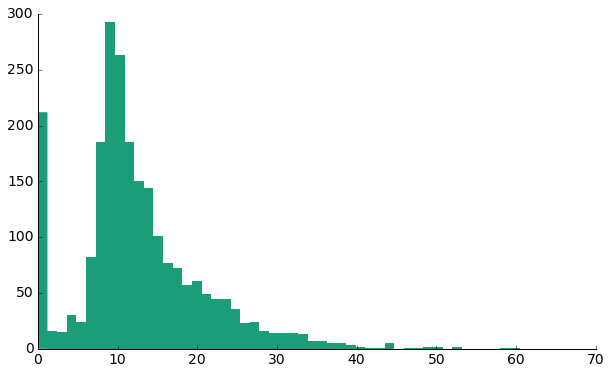

In [45]:
plt.hist(iv_df.rate_adj[((~np.isnan(iv_df.rate_adj)) & (iv_df.rate_adj < 100))], bins=50)
remove_border()

### Spouse pre-birth income

If pre-birth marital status is single or previously married, spouse income is set to 0. If pre-birth marital status is married, look for spouse wage reported in DOB year (because the spouse wage variable is defined to be TOTAL INCOME OF SPOUSE FROM WAGES AND SALARY IN PAST CALENDAR YEAR) and convert wage to 2016 dollar using DOB year -1 as the conversion year. 

In [49]:
spouse_income_df = pd.read_csv('../data/spouse_income.csv')
spouse_income_df.head()

,version_r26_2014,caseid_1979,spouse_income_1979,sample_id_1979,sample_race_78scrn,sample_sex_1979,spouse_income_1980,spouse_income_1981,spouse_income_1982,spouse_income_1983,...,q13_18_sr000002_trunc_2010,q13_18_uab_a_2010,q13_18_uab_b_2010,q13_18_uab_c_2010,q13_18_trunc_2012,q13_18_sr000001_trunc_2012,q13_18_sr000002_trunc_2012,q13_18_uab_a_2012,q13_18_uab_b_2012,q13_18_uab_c_2012
0,-5,1,-4,5,3,2,-5,-4,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,458,2,-4,5,3,2,-4,-4,-4,-4,...,-4,-4,-4,-4,0,-4,-4,-4,-4,-4
2,458,3,-4,5,3,2,-4,-5,10000,9600,...,-5,-5,-5,-5,55000,-4,-4,-4,-4,-4
3,-5,4,-4,5,3,2,-5,14000,10000,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,-5,5,-4,1,3,1,-4,-4,-4,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [47]:
iv_df.childbirth_year.unique()

array([1993, 1981, 1980, 1990, 1987, 1988, 1982, 1985, 1994, 1986, 1992,
       1989, 1991, 1984, 1995, 1983])

In [50]:
#version 2 - use spouse salary in dob year because spouse salary was reported for the past calendar year

count = defaultdict(int)
years = range(1979, 1995) + range(1996, 2013, 2)

def get_spouse_income(row):
    """
    Given respondent id i, return (spouse wage, marital status).
    Use spouse wage in DOB year. If missing, use spouse wage in DOB year - 1. 
    """
    
    dob_y = int(row['childbirth_year'])
    
    if row['marstat'] in [0, 2]: #if single or divorced/widowed/separated, return spouse wage of 0
        count[0] += 1
        if row['caseid_1979'] == 229:
            print 'here'
        return 0
    
    elif row['marstat'] == 1:
        
        if dob_y == 1995: # 1995 is not a survey year
            inc = row['spouse_income_1994']
        else:
            inc = row['spouse_income_%s'%dob_y] # income
        
        if inc >= 0:
            count['found in dob_y'] += 1
            return convert_to_current_dollar(inc, dob_y-1)  # income adjusted for inflation  
        
        else:
            prev_inc = row['spouse_income_%s'%(dob_y-1)]
            if prev_inc >= 0:
                count['found in dob_y - 1'] += 1                
                return convert_to_current_dollar(prev_inc, dob_y-2) # income adjusted for inflation  
            else:
                count['missing'] += 1
                return None
    
    # otherwise, if marital status is missing
    else:
        count['missing'] += 1
        return None
        

merged = iv_df.merge(spouse_income_df, on='caseid_1979')
merged["spouse_income_adj"] = merged.apply(get_spouse_income, axis=1)
iv_df = iv_df.merge(merged[['caseid_1979', 'spouse_income_adj']], on='caseid_1979')
iv_df.head()

here


,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,...,num_nonemp_spells,rate,report_y,start_wk,end_wk,tenure,start_year,end_year,rate_adj,spouse_income_adj
0,2,1993,3,1959,1,1993,4,34,26370.0,1,...,1,12.63,1992.0,706.0,775.0,726.0,1991.0,1992.0,21.7236,0.0
1,3,1981,6,1961,8,1981,7,19,3817.0,1,...,9,3.97,1980.0,118.0,124.0,14.0,1980.0,1980.0,12.1085,0.0
2,4,1980,8,1962,8,1980,9,18,0.0,0,...,5,0.00,NaN,NaN,NaN,0.0,NaN,NaN,0.0000,0.0
3,16,1990,2,1958,10,1990,3,31,24275.0,1,...,0,15.86,1989.0,560.0,609.0,130.0,1988.0,1989.0,31.0856,64680.0
4,19,1987,11,1957,12,1987,12,29,10241.0,1,...,1,5.65,1986.0,411.0,426.0,56.0,1985.0,1986.0,12.2040,0.0


In [51]:
print count

defaultdict(<type 'int'>, {0: 1222, 'found in dob_y - 1': 71, 'found in dob_y': 1096, 'missing': 125})


In [53]:
print 'Among the %s married respondents, %s had missing spouse wage'%(iv_df.marstat.values.tolist().count(1), sum(iv_df.spouse_income_adj.isnull()))

Among the 1281 married respondents, 125 had missing spouse wage


### Spouse's working hours

Use same rule as above. Single and previously married respondents are set to have spouse hours of 0 and spouse hour group 0. If found valid spouse hour in DOB year, use it. Otherwise, try spouse hours in the year before DOB year. 

In [54]:
sphour_df = pd.read_csv('../data/spouse_work_hours.csv')
sphour_df.head()

,caseid_1979,sample_race_1979,sample_sex_1979,spouse_hr_per_wk_1980,spouse_hr_per_wk_1981,spouse_hr_per_wk_1982,spouse_hr_per_wk_1983,spouse_hr_per_wk_1984,spouse_hr_per_wk_1985,spouse_hr_per_wk_1986,...,spouse_hr_per_wk_1994,spouse_hr_per_wk_1996,spouse_hr_per_wk_1998,spouse_hr_per_wk_2000,spouse_hr_per_wk_2002,spouse_hr_per_wk_2004,spouse_hr_per_wk_2006,spouse_hr_per_wk_2008,spouse_hr_per_wk_2010,spouse_hr_per_wk_2012
0,1,3,2,-5,-4,-5,-5,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,3,2,-4,-4,-4,-4,-4,-4,-4,...,37,35,37,40,40,40,-4,-4,-4,-4
2,3,3,2,-4,-5,40,38,40,50,60,...,76,50,50,40,40,-5,40,40,-5,40
3,4,3,2,-5,51,42,90,-4,-4,-2,...,-5,40,40,-5,-5,-5,-5,-5,-5,-5
4,5,3,1,-4,-4,-4,-4,-4,-5,40,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [56]:
count = defaultdict(int)

def get_spouse_hour(row):
    """Given a row of respondent data, return spouse's typical hours worked per week."""
    
    dob_y = int(row['childbirth_year'])
    marstat_prev = row["marstat"] 
    
    if dob_y == 1995: # not in survey year
        hour = row['spouse_hr_per_wk_1994'] 
    else:
        hour = row['spouse_hr_per_wk_%s'%dob_y] 
    #it is one year pre-birth, but some weird naming convention in NLSY79 makes spouse_hr_per_wk_1980 represents 1979 data
    
    if marstat_prev==0: #if single, return spouse hour of 0
        if hour >= 0: # some cases where single or previously married respondents had positive spouse hours!!!
            count[0] += 1
        return 0
    
    elif marstat_prev==2: #if divorced/widowed/separated, return spouse hour of 0
        if hour >= 0:
            count[2] += 1
        return 0
    
    elif marstat_prev==1: #if married, but spouse hour is missing, impute from surrounding years
        
        if hour >= 0:
            count["hour in dob_y"] += 1
            return hour
        
        if dob_y > 1980: # variable only start in 1980
            hour_prev = sphour_df[sphour_df.caseid_1979==i].iloc[0]['spouse_hr_per_wk_%s'%(dob_y-1)] 
            if hour_prev >= 0:
                count["hour in dob_y - 1"] += 1
                return hour_prev
        
    count["missing"] += 1
    return None


merged = iv_df.merge(sphour_df, on='caseid_1979')
merged['sphour'] = merged.apply(get_spouse_hour, axis=1)
iv_df = iv_df.merge(merged[['caseid_1979', 'sphour']], on='caseid_1979')

In [57]:
print count

defaultdict(<type 'int'>, {0: 302, 'hour in dob_y': 1163, 2: 33, 'missing': 129})


In [58]:
#edit hours into categories:
#0-spouse < FT (less than 35 hours per week), 1-full time (35-50 hours per week), 2-overwork (>50 hours per week)

def group_sphours(h):
    
    if h==None:
        return None
    
    elif np.isnan(h):
        return None

    elif h<35: # less than full-time
        return 0
    
    elif h>=35 and h<=50:
        return 1
    
    elif h>50:
        return 2
    
    else:
        print 'unknown hours'
        return None
        

In [59]:
iv_df["sphour_group"] = iv_df.sphour.map(group_sphours)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,...,report_y,start_wk,end_wk,tenure,start_year,end_year,rate_adj,spouse_income_adj,sphour,sphour_group
0,2,1993,3,1959,1,1993,4,34,26370.0,1,...,1992.0,706.0,775.0,726.0,1991.0,1992.0,21.7236,0.0,0.0,0.0
1,3,1981,6,1961,8,1981,7,19,3817.0,1,...,1980.0,118.0,124.0,14.0,1980.0,1980.0,12.1085,0.0,0.0,0.0
2,4,1980,8,1962,8,1980,9,18,0.0,0,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0000,0.0,0.0,0.0
3,16,1990,2,1958,10,1990,3,31,24275.0,1,...,1989.0,560.0,609.0,130.0,1988.0,1989.0,31.0856,64680.0,60.0,2.0
4,19,1987,11,1957,12,1987,12,29,10241.0,1,...,1986.0,411.0,426.0,56.0,1985.0,1986.0,12.2040,0.0,0.0,0.0


## Export to csv

In [60]:
#export to csv
iv_df.to_csv('../data/iv_df_subsample.csv', index=False)

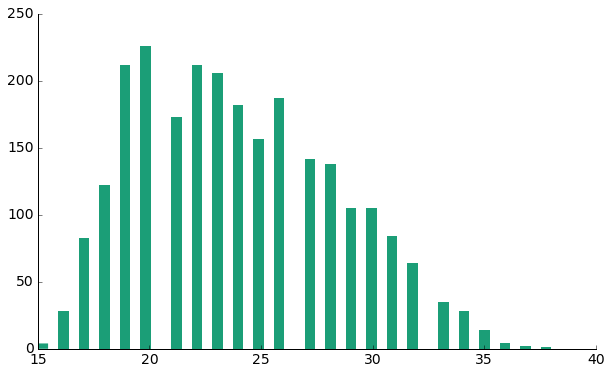

In [61]:
plt.hist(iv_df.age, bins=50)
remove_border()